# Introducing the Dataset

## Getting an Overview of the Data with Pandas

In [1]:
import pandas as pd

file = "../99 text/data/un-general-debates/un-general-debates-blueprint.csv"
df = pd.read_csv(file)
df.sample(2)

,session,year,country,country_name,speaker,position,text
2972,46,1991,LBY,Libya,BISHARI,NaN,﻿On behalf of the delegation of the great Liby...
4968,57,2002,QAT,Qatar,Nassir Abdulaziz Al-Nasser,UN Representative,"﻿I would like to thank you,\nSir, for giving m..."


### Calculating Summary Statistics for Columns

In [2]:
df['length'] = df['text'].str.len()

df.describe().T

,count,mean,std,min,25%,50%,75%,max
session,7507.0,49.610763,12.892155,25.0,39.0,51.0,61.0,70.0
year,7507.0,1994.610763,12.892155,1970.0,1984.0,1996.0,2006.0,2015.0
length,7507.0,17967.281604,7860.038463,2362.0,12077.0,16424.0,22479.5,72041.0


In [3]:
df[['country', 'speaker']].describe(include='O').T

,count,unique,top,freq
country,7507,199,ALB,46
speaker,7480,5428,Seyoum Mesfin,12


### Checking for Missing Data

In [4]:
df.isna().sum()

session            0
year               0
country            0
country_name       0
speaker           27
position        3005
text               0
length             0
dtype: int64

In [5]:
df['speaker'].fillna('unkonwn', inplace=True)

/tmp/ipykernel_4588/2421793358.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['speaker'].fillna('unkonwn', inplace=True)


In [6]:
df[df['speaker'].str.contains('Bush')]['speaker'].value_counts()

speaker
George W. Bush        4
Mr. George W. Bush    2
Bush                  1
George Bush           1
Mr. George W Bush     1
Name: count, dtype: int64

### Plotting Value Distributions

<Axes: >

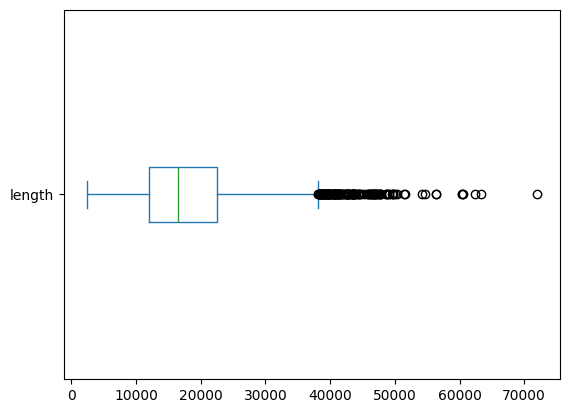

In [7]:
df['length'].plot(kind='box', vert=False)

<Axes: ylabel='Frequency'>

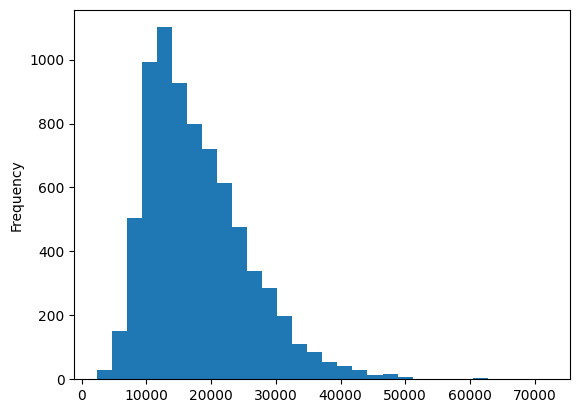

In [8]:
df['length'].plot(kind='hist', bins=30)

### Comparing Value Distributions Across Categories

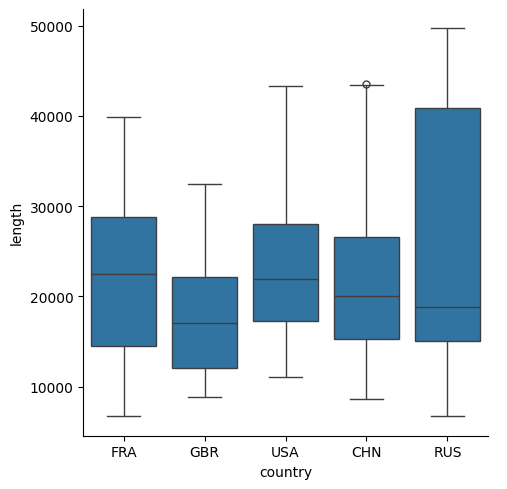

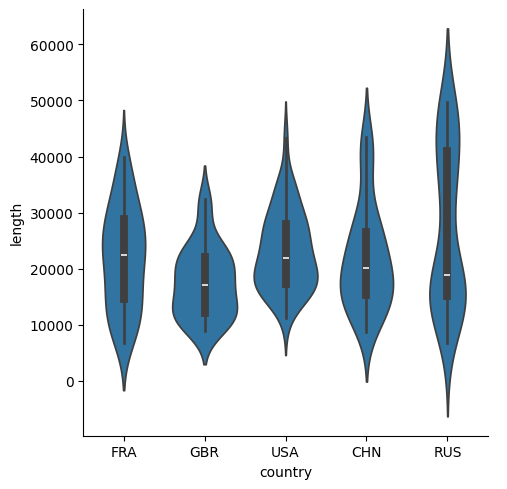

In [9]:
import seaborn as sns
from matplotlib import pyplot as plt

where = df['country'].isin(['USA', 'FRA', 'GBR', 'CHN', 'RUS'])
sns.catplot(data=df[where], x='country', y='length', kind='box')
sns.catplot(data=df[where], x='country', y='length', kind='violin')

### Visualizing Development Over Time

<Axes: title={'center': 'Number of countries'}, xlabel='year'>

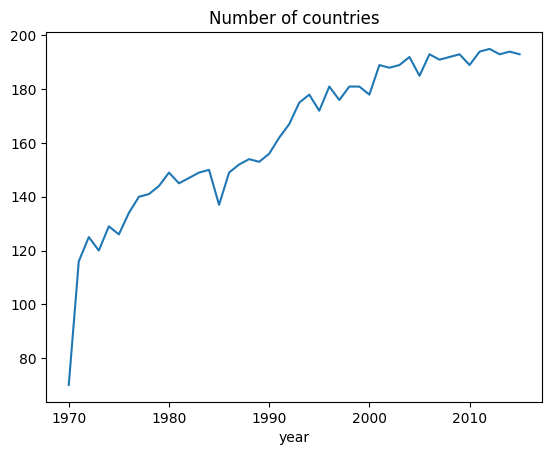

In [10]:
df.groupby('year').size().plot(title='Number of countries')

<Axes: title={'center': 'Avg. Speech Length'}, xlabel='year'>

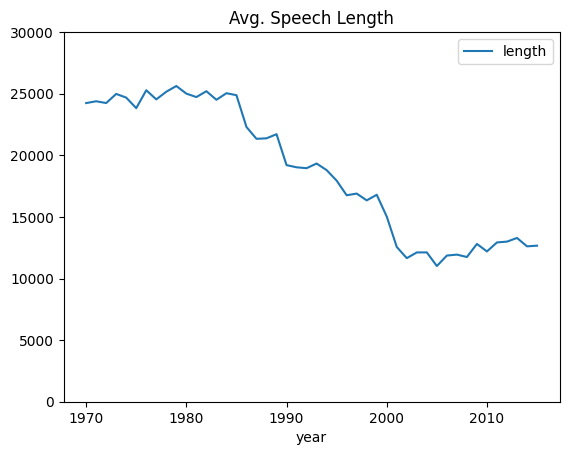

In [11]:
df.groupby('year').agg({'length': 'mean'}) \
    .plot(title='Avg. Speech Length', ylim=(0, 30000))

## Building a Simple Text Preprocessing Pipeline

### Performing Tokenizatin with Regular Expressions

In [12]:
import regex as re

def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [13]:
text = "Let's defeat SARS-CoV-2 together in 2020!"
tokens = tokenize(text)
print("|".join(tokens))

Let|s|defeat|SARS-CoV-2|together|in


### Treating Stop Words

In [14]:
import nltk

stopwords = set(nltk.corpus.stopwords.words('english'))

In [15]:
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

In [16]:
include_stopwords = {'dear', 'regards', 'must', 'would', 'also'}
exclude_stopwords = {'against'}

stopwords |= include_stopwords
stopwords -= exclude_stopwords

### Processing a Pipeline with One Line of Code

In [17]:
pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [18]:
df['tokens'] = df['text'].apply(prepare, pipeline=pipeline)
df['num_tokens'] = df['tokens'].map(len)

# Blueprints for Word Frequency Analysis

## Counting Words with a Counter

In [19]:
from collections import Counter

tokens = tokenize("She likes my cats and my cats like my sofa.")

counter = Counter(tokens)
print(counter)

Counter({'my': 3, 'cats': 2, 'She': 1, 'likes': 1, 'and': 1, 'like': 1, 'sofa': 1})


In [20]:
more_tokens = tokenize("She likes dogs and cats.")
counter.update(more_tokens)
print(counter)

Counter({'my': 3, 'cats': 3, 'She': 2, 'likes': 2, 'and': 2, 'like': 1, 'sofa': 1, 'dogs': 1})


In [21]:
counter = Counter()
df['tokens'].map(counter.update)

0       None
1       None
2       None
3       None
4       None
        ... 
7502    None
7503    None
7504    None
7505    None
7506    None
Name: tokens, Length: 7507, dtype: object

In [22]:
print(counter.most_common(5))

[('nations', 124508), ('united', 120763), ('international', 117223), ('world', 89421), ('countries', 85734)]


In [23]:
def count_words(df, column = 'tokens', preprocess = None, min_freq = 2):
    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    #transform counter to DataFrame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)

In [24]:
freq_df = count_words(df)
freq_df.head()

,freq
token,
nations,124508
united,120763
international,117223
world,89421
countries,85734


In [25]:
count_words(df, column='text', preprocess=lambda x: re.findall(r'\w{10,}', x)).head()

,freq
token,
international,106974
development,51334
Government,35528
Organization,33763
developing,25177


## Creating a Frequency Diagram

[Text(0.5, 0, 'Frequency'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'Most Frequent Tokens')]

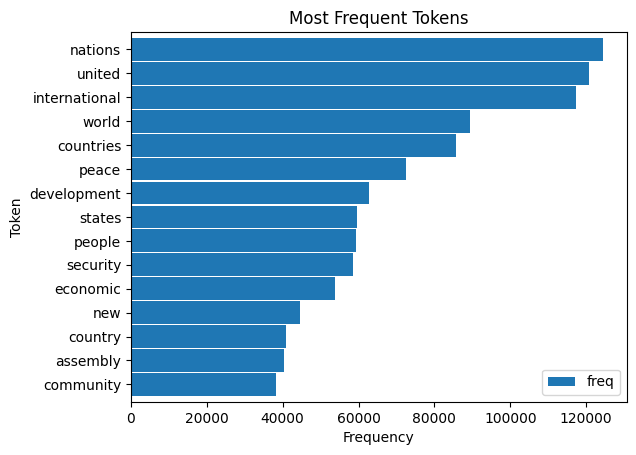

In [26]:
ax = freq_df.head(15).plot(kind='barh', width=0.95)
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Most Frequent Tokens')

## Creating Word Clouds

(-0.5, 399.5, 199.5, -0.5)

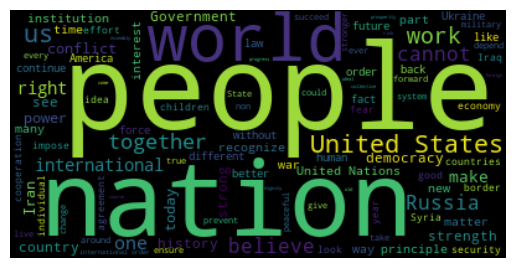

In [27]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

text = df.query('year == 2015 and country=="USA"')['text'].values[0]

wc = WordCloud(max_words=100, stopwords=stopwords)
wc.generate(text)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')

In [28]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400,
                   background_color='black', colormap='Paired',
                   max_font_size=150, max_words=max_words)
    
    #convert DataFrame to dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    #filter stop words in frequency counter
    if stopwords is not None:
        counter = {token: freq for token, freq in counter.items() 
                   if token not in stopwords}
    wc.generate_from_frequencies(counter)

    plt.title(title)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')

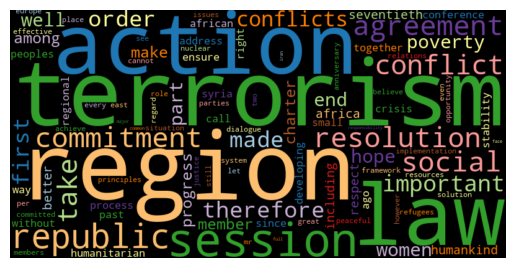

In [29]:
freq_2015_df = count_words(df[df['year'] == 2015])
#plt.figure()
wordcloud(freq_2015_df['freq'], max_words=100)
wordcloud(freq_2015_df['freq'], max_words=100, stopwords=freq_2015_df.head(50).index)

## Ranking with TF-IDF

In [30]:
import numpy as np

def compute_idf(df, column='tokens', preprocess=None, min_df=2):

    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))

    #count tokens
    counter = Counter()
    df[column].map(update)

    #create DataFrame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df


In [31]:
idf_df = compute_idf(df)
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

/tmp/ipykernel_4588/2775196155.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1


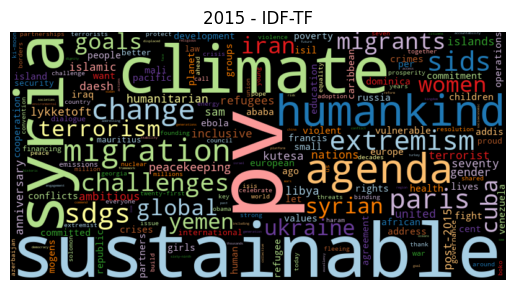

In [32]:
freq_1970 = count_words(df[df['year'] == 1970])
freq_2015 = count_words(df[df['year'] == 2015])

freq_1970['tfidf'] = freq_1970['freq'] * idf_df['idf']
freq_2015['tfidf'] = freq_2015['freq'] * idf_df['idf']

wordcloud(freq_1970['freq'], title='1970 - TF', 
          stopwords=['twenty-fifth', 'twenty-five'])
wordcloud(freq_2015['freq'], title='2015 - TF', 
          stopwords=['seventieth'])
wordcloud(freq_1970['tfidf'], title='1970 - IDF-TF', 
          stopwords=['twenty-fifth', 'twenty-five', 'twenty', 'fifth'])
wordcloud(freq_2015['tfidf'], title='2015 - IDF-TF', 
          stopwords=['seventieth'])

## Finding a Keyword-in-Context

In [33]:
from textacy.extract.kwic import keyword_in_context
import random

def kwic(doc_series, keyword, window=35, print_samples=5):

    def add_kwic(text):
        kwic_list.extend(keyword_in_context(text, keyword, ignore_case=True, 
                              window_width=window))
        
    kwic_list = []
    doc_series.map(add_kwic)

    if print_samples is None or print_samples == 0:
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        print(f'{k} random samples out of {len(kwic_list)} ' + \
              f'contexts for {keyword}:')
        for sample in random.sample(kwic_list, k):
            print(re.sub(r'[\n\t]', ' ', sample[0])+' ' + \
                  sample[1] + ' ' + \
                  re.sub(r'[\n\t]', ' ', sample[2])) 

In [34]:
kwic(df[df['year'] == 2015]['text'], 'sdgs', print_samples=5)

5 random samples out of 73 contexts for sdgs:
the Sustainable Development Goals ( SDGs ). In other words, it is addressing
the Sustainable Development Goals ( SDGs ). We applaud all the Chairs of the
notably through discussions on the  SDGs  and the 2030 Agenda for Sustainabl
 of Sustainable Development Goals ( SDGs ). Given the ambition reflected in 
the Sustainable Development Goals ( SDGs ) will be an effective tool in glob


## Analyzing N-Grams

In [35]:
def ngrams(tokens, n=2, sep=' '):
    return[sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

text = "the visible manifestation of the global climate change"
tokens = tokenize(text)
print("|".join(ngrams(tokens, n=2)))

the visible|visible manifestation|manifestation of|of the|the global|global climate|climate change


In [36]:
def ngrams(tokens, n=2, sep=' ', stopwords=set()):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])
            if len([t for t in ngram if t in stopwords]) == 0]

print("Bigrams:", "|".join(ngrams(tokens, n=2, stopwords=stopwords)))
print("Trigrams:", "|".join(ngrams(tokens, n=3, stopwords=stopwords)))

Bigrams: visible manifestation|global climate|climate change
Trigrams: global climate change


In [37]:
df['bigrams'] = df['text'].apply(prepare, pipeline=[str.lower, tokenize]) \
    .apply(ngrams, n=2, stopwords=stopwords)

count_words(df, column='bigrams').head(5)

,freq
token,
united nations,103236
international community,27786
general assembly,27096
security council,20961
human rights,19856


/tmp/ipykernel_4588/2775196155.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1


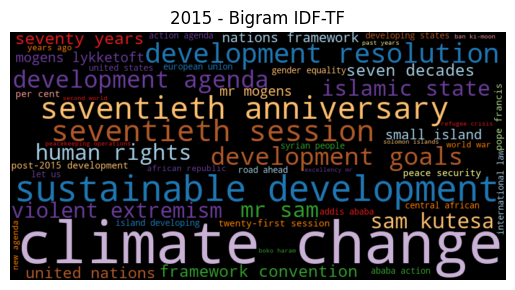

In [38]:
# concatenate existing IDF DataFrame with bigram IDFs
idf_df = pd.concat([idf_df, compute_idf(df, 'bigrams', min_df=10)])

freq_df = count_words(df[df['year'] == 2015], 'bigrams')
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']
wordcloud(freq_df['tfidf'], title='2015 - Bigram IDF-TF', max_words=50)

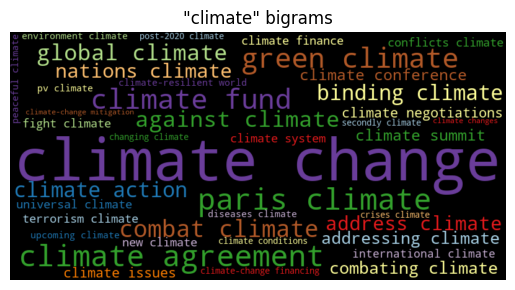

In [39]:
where = freq_df.index.str.contains('climate')
wordcloud(freq_df[where]['freq'], title='"climate" bigrams', max_words=50)

## Comparing Frequencies Accross Time Intervals and Categories

### Creating Frequency Timelines

In [40]:
def count_keywords(tokens, keywords):
    tokens = [t for t in tokens if t in keywords]
    counter = Counter(tokens)
    return [counter.get(k,0) for k in keywords]

In [41]:
keywords = ['nuclear', 'terrorism', 'climate', 'freedom']
tokens = ['nuclear', 'climate', 'climate', 'freedom', 'climate', 'freedom']

print(count_keywords(tokens, keywords))

[1, 0, 3, 2]


In [46]:
def count_keywords_by(df, by, keywords, column='tokens'):
    freq_matrix = df[column].apply(count_keywords, keywords = keywords)
    freq_df = pd.DataFrame.from_records(freq_matrix, columns = keywords)
    freq_df[by] = df[by] # copy the grouping column(s)

    return freq_df.groupby(by=by).sum().sort_values(by)

In [47]:
freq_df = count_keywords_by(df, by='year', keywords=keywords)

freq_df

,nuclear,terrorism,climate,freedom
year,,,,
1970,192,7,18,128
1971,275,9,35,205
1972,393,379,74,280
1973,347,124,79,266
1974,478,24,71,316
1975,578,20,53,232
1976,451,146,57,347
1977,675,75,58,321
1978,550,82,52,309


<Axes: xlabel='year'>

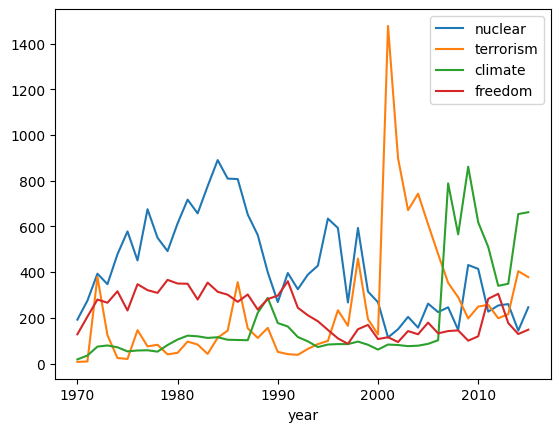

In [48]:
freq_df.plot(kind='line')

### Creating Frequency Heatmaps

<Axes: xlabel='year'>

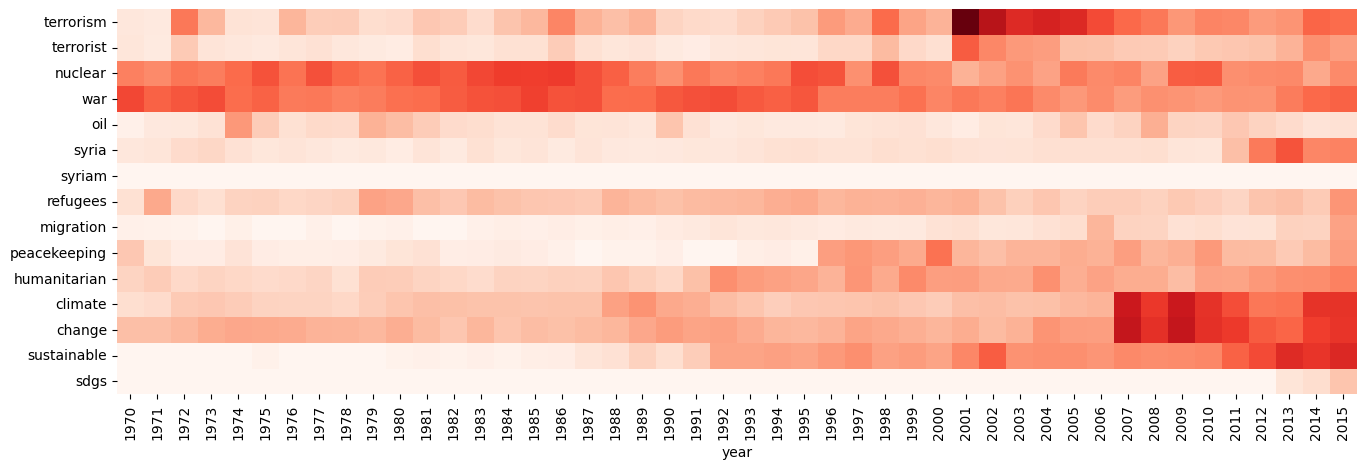

In [52]:
keywords = ['terrorism', 'terrorist', 'nuclear', 'war', 'oil', 
            'syria', 'syriam', 'refugees', 'migration', 'peacekeeping',
            'humanitarian', 'climate', 'change', 'sustainable', 'sdgs']

freq_df = count_keywords_by(df, by='year', keywords=keywords)

# compute relative freequencies based on total number of tokens per year
freq_df = freq_df.div(df.groupby('year')['num_tokens'].sum(), axis=0)
# apply square root as sublinear filter for better contrast
freq_df = freq_df.apply(np.sqrt)

# Set the figure size
plt.figure(figsize=(16, 5))

sns.heatmap(data=freq_df.T,
            xticklabels=True, yticklabels=True, cbar=False, cmap='Reds')